In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import datetime as dt

In [2]:
%%time
df = pd.read_csv('/home/alfadata/data/churn/final_dataframe_sample_ten_millions.csv')

CPU times: user 15.3 s, sys: 2.19 s, total: 17.5 s
Wall time: 1min 13s


In [2]:
%%time
df = pd.read_hdf('/home/alfadata/data/churn/final_dataframe.h5', 'df')

### Drop dates before 01.01.2016 due to no data in epay_operation

In [49]:
df.shape

(10000000, 22)

In [5]:
df['week_start'] = pd.to_datetime(df['week_start'])

In [6]:
df = df.loc[df['week_start'] > '2016-01-01']

In [51]:
df.shape

(6172833, 22)

### Fill NaN

In [7]:
def fill_age(x):
    delta_day = 7/365.5
    age_add_range = pd.Series(range(len(x)), index=x.index)*delta_day
    first_val_idx = x.first_valid_index()
    first_idx_in_series = first_val_idx - x.index[0]
    to_fill = age_add_range + (x[first_val_idx] - first_idx_in_series*delta_day)
    return x.fillna(to_fill)

In [8]:
%%time
df.isnull().sum(axis=0)

client_pin                      0
week_start                      0
target                          0
sum_card_trans_rur       53373475
count_card_trans         53373475
num_cardtype             53373475
age                      64296680
gender_uk                64296680
country_uk               64296680
success_login            64296680
unsuccess_login          64296680
client_life_span         64296680
count_debit              53373475
count_credit             53373475
sum_epay_rur             77512952
count_epay_rur           77512931
sum_epay_fee             77512952
count_epay_fee           77512931
confirmed_eoperations    77512931
rejected_eoperations     77512931
sum_draw_rur             88279110
count_draw_trans         88279100
dtype: int64

In [9]:
%%time
df['age'] = df.groupby('client_pin')['age'].apply(lambda x: fill_age(x) if x.notnull().sum() != 0 else x.fillna(0))

CPU times: user 22min 50s, sys: 25.1 s, total: 23min 15s
Wall time: 23min 15s


In [10]:
%%time
df['gender_uk'] = df.groupby('client_pin')['gender_uk'].transform(lambda x: x.bfill().ffill())

CPU times: user 9min 32s, sys: 18.4 s, total: 9min 50s
Wall time: 9min 35s


In [11]:
%%time 
df = df.fillna(0)

CPU times: user 31.7 s, sys: 4.17 s, total: 35.8 s
Wall time: 35.9 s


### Plots

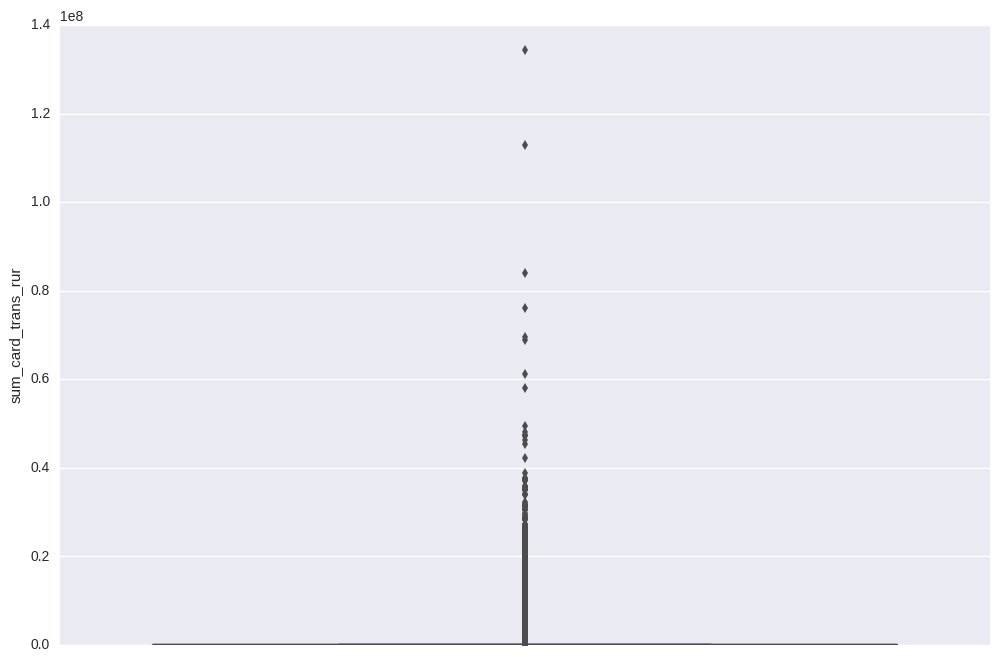

In [12]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(df.sum_card_trans_rur, ax=ax, orient='vertical')

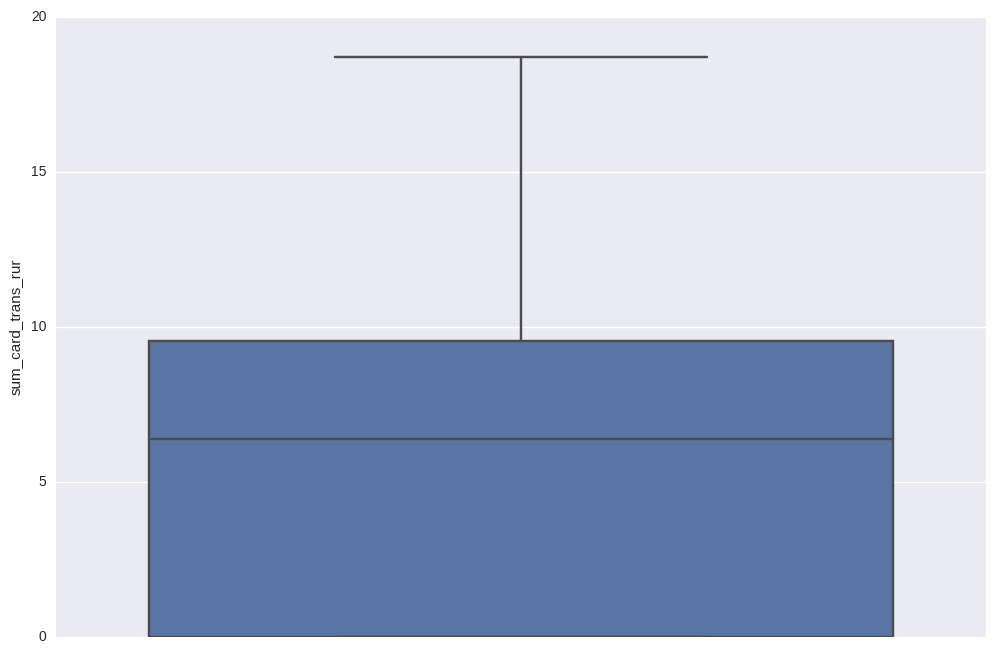

In [92]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(np.log(df.sum_card_trans_rur+1),ax=ax, orient='vertical')

In [85]:
df.sum_card_trans_rur.isnull().sum()

0

In [86]:
df.sum_card_trans_rur.isnull().shape

(6172833,)

In [36]:
sum_card_trans = df.sum_card_trans_rur.dropna()

In [260]:
max_limit = sum_card_trans.quantile(0.75) + (sum_card_trans.quantile(0.75) - sum_card_trans.quantile(0.25))*1.5

In [261]:
max_limit

92203.0

In [262]:
len(sum_card_trans[sum_card_trans>max_limit]), len(sum_card_trans)

(602901, 4751313)

/opt/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


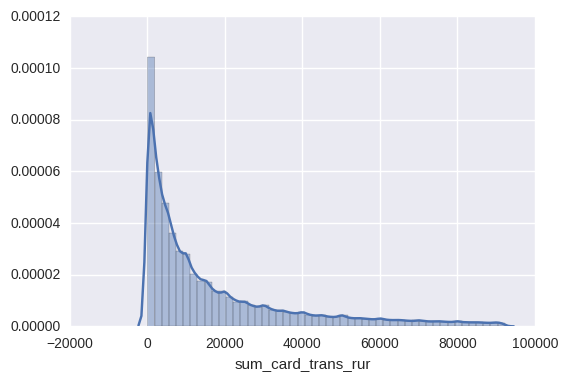

In [89]:
sns.distplot(sum_card_trans[sum_card_trans<max_limit])

In [42]:
(sum_card_trans > max_limit).sum(), (sum_card_trans <= max_limit).sum()

(393798, 4357515)

### Features

In [22]:
mask_client = df.client_pin == 'AF67ZC'

In [43]:
df.columns.tolist()

['client_pin',
 'week_start',
 'target',
 'count_debit',
 'count_credit',
 'sum_card_trans_rur',
 'count_card_trans',
 'num_cardtype',
 'age',
 'gender_uk',
 'country_uk',
 'success_login',
 'unsuccess_login',
 'client_life_span',
 'sum_draw_rur',
 'count_draw_trans',
 'sum_epay_rur',
 'count_epay_rur',
 'sum_epay_fee',
 'count_epay_fee',
 'confirmed_eoperations',
 'rejected_eoperations']

In [64]:
# q = df[mask_client][[ 'client_pin', 'week_start', 'success_login', 'count_card_trans', 'confirmed_eoperations']].fillna(0)
q = df[mask_client][[ 'client_pin', 'week_start', 'success_login']].fillna(0)

In [65]:
q['success_login_lag1'] = q.groupby('client_pin')['success_login'].shift(1)

In [66]:
q['success_login_cumsum'] = q.groupby('client_pin')['success_login'].cumsum()
q['success_login_cumsum_lag1'] = q.groupby('client_pin')['success_login_cumsum'].shift(1)
q['success_login_cumsum_lag4'] = q.groupby('client_pin')['success_login_cumsum'].shift(4)
q['success_login_cumsum_lag12'] = q.groupby('client_pin')['success_login_cumsum'].shift(12)
q = q.drop('success_login_cumsum', axis=1)

In [ ]:
q['success_login_rolling_sum1'] = q.groupby('client_pin')['success_login'].rolling(1, min_periods=1).sum()
q['success_login_rolling_sum4'] = q.groupby('client_pin')['success_login'].rolling(4, min_periods=4).sum()
q['success_login_rolling_sum12'] = q.groupby('client_pin')['success_login'].rolling(12, min_periods=12).sum()

In [41]:
# q['success_login'] - q['success_login'].shift(1)

In [42]:
# df.iloc[0]

In [8]:
# pool = multiprocessing.Pool(40)

# reader = pd.read_csv('/home/alfadata/data/churn/final_dataframe_sample_million.csv', chunksize=1000)

# %%time
# l = []

In [76]:
df.head()

,client_pin,week_start,target,count_debit,count_credit,sum_card_trans_rur,count_card_trans,num_cardtype,age,gender_uk,...,unsuccess_login,client_life_span,sum_draw_rur,count_draw_trans,sum_epay_rur,count_epay_rur,sum_epay_fee,count_epay_fee,confirmed_eoperations,rejected_eoperations
0,AF67T3,2016-02-08,1.0,NaN,NaN,NaN,NaN,NaN,34.528044,1.0,...,0.0,1335.0,NaN,NaN,14111.0,3.0,0.0,0.0,3.0,0.0
1,AF67T3,2016-02-15,1.0,NaN,NaN,NaN,NaN,NaN,34.547196,1.0,...,0.0,1342.0,NaN,NaN,85500.0,6.0,390.0,2.0,5.0,1.0
2,AF67T3,2016-02-22,1.0,NaN,NaN,NaN,NaN,NaN,34.566347,1.0,...,0.0,1349.0,145950.0,3.0,144450.0,3.0,0.0,0.0,2.0,1.0
3,AF67T3,2016-02-29,1.0,NaN,NaN,NaN,NaN,NaN,34.585499,1.0,...,0.0,1356.0,NaN,NaN,42500.0,5.0,264.0,2.0,4.0,1.0
4,AF67T3,2016-03-07,1.0,NaN,NaN,NaN,NaN,NaN,34.604651,1.0,...,0.0,1363.0,NaN,NaN,11150.0,3.0,110.0,1.0,3.0,0.0


### ML построим несколько алгоритмов что бы посмотреть baseline по моделям

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, auc, precision_recall_curve, roc_curve, 
    precision_score, recall_score)
from xgboost import XGBClassifier
import xgboost as xgb

In [159]:
clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=632, n_jobs=-1)

In [104]:
X.head()

,client_pin,week_start,sum_card_trans_rur,count_card_trans,num_cardtype,age,gender_uk,country_uk,success_login,unsuccess_login,...,count_debit,count_credit,sum_epay_rur,count_epay_rur,sum_epay_fee,count_epay_fee,confirmed_eoperations,rejected_eoperations,sum_draw_rur,count_draw_trans
31,A00327,2016-01-04,0.0,0.0,0.0,51.668947,1.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,A00327,2016-01-11,356106.0,6.0,11.0,51.688098,1.0,5.212618e+09,5.0,0.0,...,5.0,0.0,1110000.0,7.0,0.0,0.0,5.0,2.0,0.0,0.0
33,A00327,2016-01-18,0.0,0.0,0.0,51.707250,1.0,5.212618e+09,2.0,0.0,...,0.0,0.0,270000.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
34,A00327,2016-01-25,2162797.0,10.0,11.0,51.726402,1.0,0.000000e+00,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,A00327,2016-02-01,110260.0,1.0,11.0,51.745554,1.0,5.212618e+09,5.0,0.0,...,5.0,0.0,1815000.0,7.0,0.0,0.0,5.0,2.0,0.0,0.0


In [14]:
uniq_pins = df.client_pin.unique()

In [15]:
train_len = int(len(uniq_pins) * 0.7)
train_pin = uniq_pins[:train_len]

In [16]:
train_idx = df.loc[df['client_pin'].isin(train_pin)].index
test_idx = df.loc[~df['client_pin'].isin(train_pin)].index

In [17]:
test_idx.shape[0], train_idx.shape[0]

(26828800, 62600450)

In [18]:
test_idx.shape[0]/df.shape[0]

0.30000027955059444

In [162]:
cols_to_drop = ['target', 'client_pin', 'week_start']
X_train = df.loc[train_idx].drop(cols_to_drop, axis=1)
y_train = df.loc[train_idx]['target']

X_test = df.loc[test_idx].drop(cols_to_drop, axis=1)
y_test = df.loc[test_idx]['target']

In [164]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=632, verbose=0, warm_start=False)

In [165]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=632, verbose=0, warm_start=False)

In [168]:
preds = clf.predict(X_test)
preds_prob = clf.predict_proba(X_test)[:, 1]

In [228]:
def pr_auc_score(y_true, y_pred_prob):
    precisions, recalls, _ = precision_recall_curve(y_true, y_pred_prob)
    return auc(recalls, precisions)

dict_func_scores = ({'roc_auc_score': roc_auc_score, 
    'accuracy_score': accuracy_score,      
    'f1_score': f1_score,      
    'pr_auc_score': pr_auc_score,      
    'precision': precision_score,      
    'recall': recall_score   
    })

In [241]:
scores = {key:[] for key in dict_func_scores}

In [242]:
scores

{'accuracy_score': [],
 'f1_score': [],
 'pr_auc_score': [],
 'precision': [],
 'recall': [],
 'roc_auc_score': []}

In [243]:
y_true = y_test
y_pred = preds
y_pred_prob = preds_prob

In [244]:
for key, func in dict_func_scores.items():
    if key in ['pr_auc_score', 'roc_auc_score']:
        scores[key].append(func(y_true, y_pred_prob))
    else:
        scores[key].append(func(y_true, y_pred))

In [329]:
clfs = ([
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=632, n_jobs=-1),
#     RandomForestClassifier(n_estimators=200, max_depth=5, random_state=632, n_jobs=-1),
#     RandomForestClassifier(n_estimators=100, max_depth=10, random_state=632, n_jobs=-1)
])

In [330]:
# scores = {key:[] for key in dict_func_scores}
clf_stats ={}
clf_stats['clf_name'] = []
clf_stats['clf_params'] = []
clf_stats['clf'] = []
clf_stats['scores'] = []

In [332]:
for clf in clfs:
    start_time = dt.datetime.now()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    scores = {}
    for key, func in dict_func_scores.items():
        if key in ['pr_auc_score', 'roc_auc_score']:
            scores[key] = func(y_true, y_pred_prob)
        else:
            scores[key] = func(y_true, y_pred)
        
    clf_stats['clf_name'].append(repr(clf).split('(')[0])
    clf_stats['clf_params'].append(clf.get_params())
    clf_stats['clf'].append(clf)
    clf_stats['scores'].append(scores)
    
    print('{} is finished for {:.1f} seconds'.format(clf_stats['clf_name'][-1], 
                                                     (dt.datetime.now() - start_time).total_seconds()))

RandomForestClassifier is finished for 52.7 seconds
RandomForestClassifier is finished for 44.0 seconds
RandomForestClassifier is finished for 35.2 seconds


#### Посмотрим важность переменных по information gain в случайном лесе

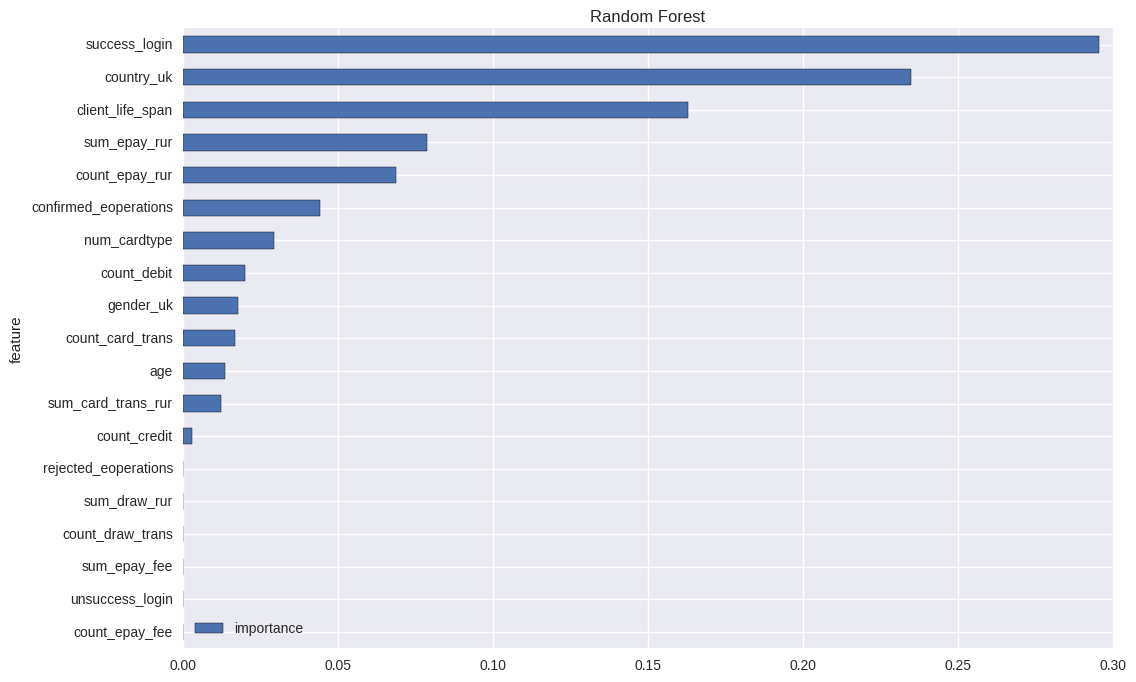

In [338]:
df_importance = pd.DataFrame(list(zip(X_train.columns, clf.feature_importances_)), columns=['feature', 'importance'])
df_importance.sort_values(by='importance', ascending=True).plot(x='feature', kind='barh', figsize=(12, 8), title='Random Forest')

#### Посмотрим скоррелированность всех параметров что мы добавили в модель

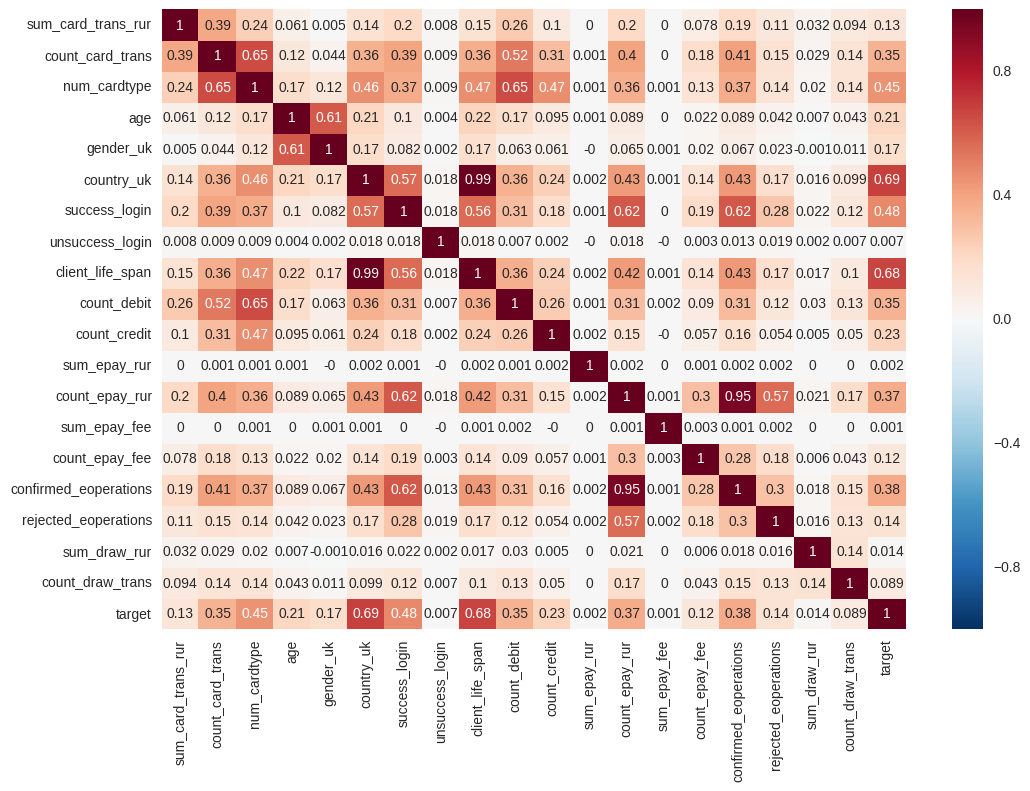

In [292]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr().round(3), annot=True, ax=ax)

In [313]:
clfx = XGBClassifier(n_estimators=122, max_depth=6, learning_rate=0.1, seed=632)

clfx.fit(X_train, y_train, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], 
         early_stopping_rounds=100, verbose=True)

#### Посмотрим важность переменных по information gain в XGBoost

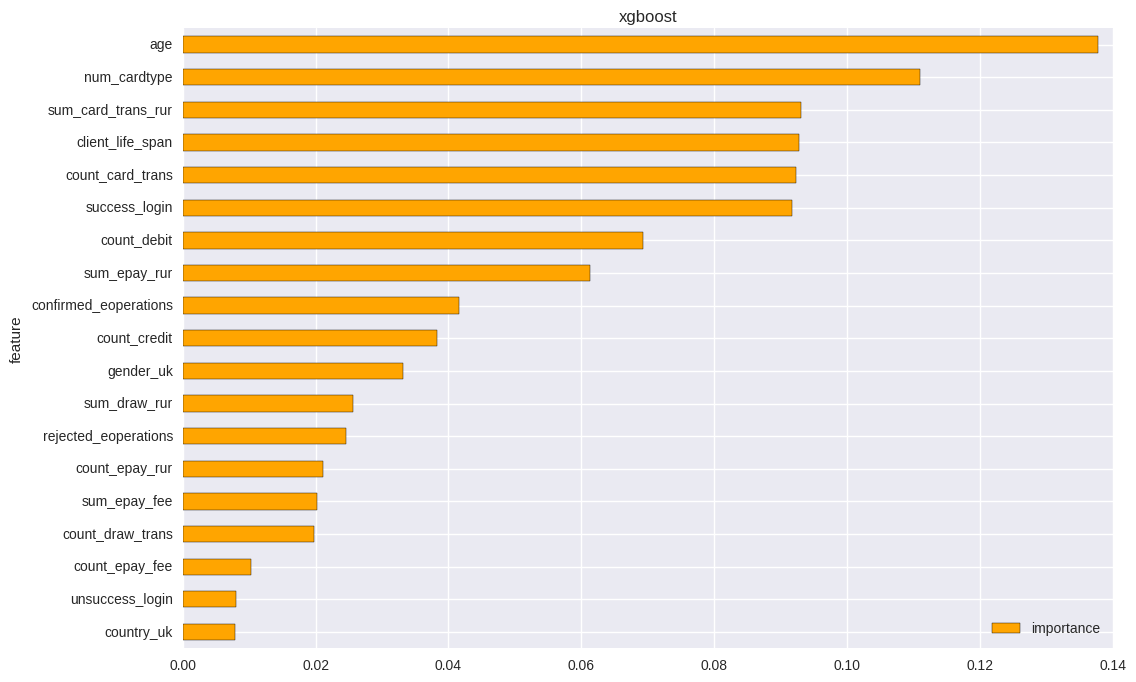

In [333]:
df_importance = pd.DataFrame(list(zip(X_train.columns, clfx.feature_importances_)), columns=['feature', 'importance'])
df_importance.sort_values(by='importance', ascending=True).plot(x='feature', kind='barh', figsize=(12, 8), color='orange',
                                                               title='xgboost')

#### Посмотрим на наш ROC-AUC

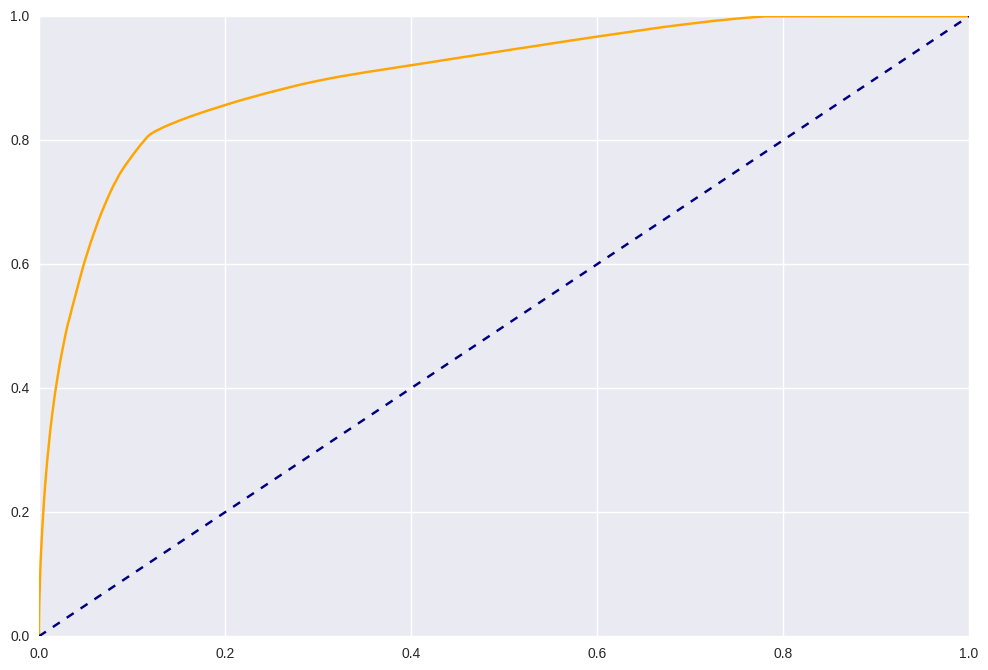

In [199]:
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='orange')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')

#### Посмотрим на сооношение охвата и точности модели

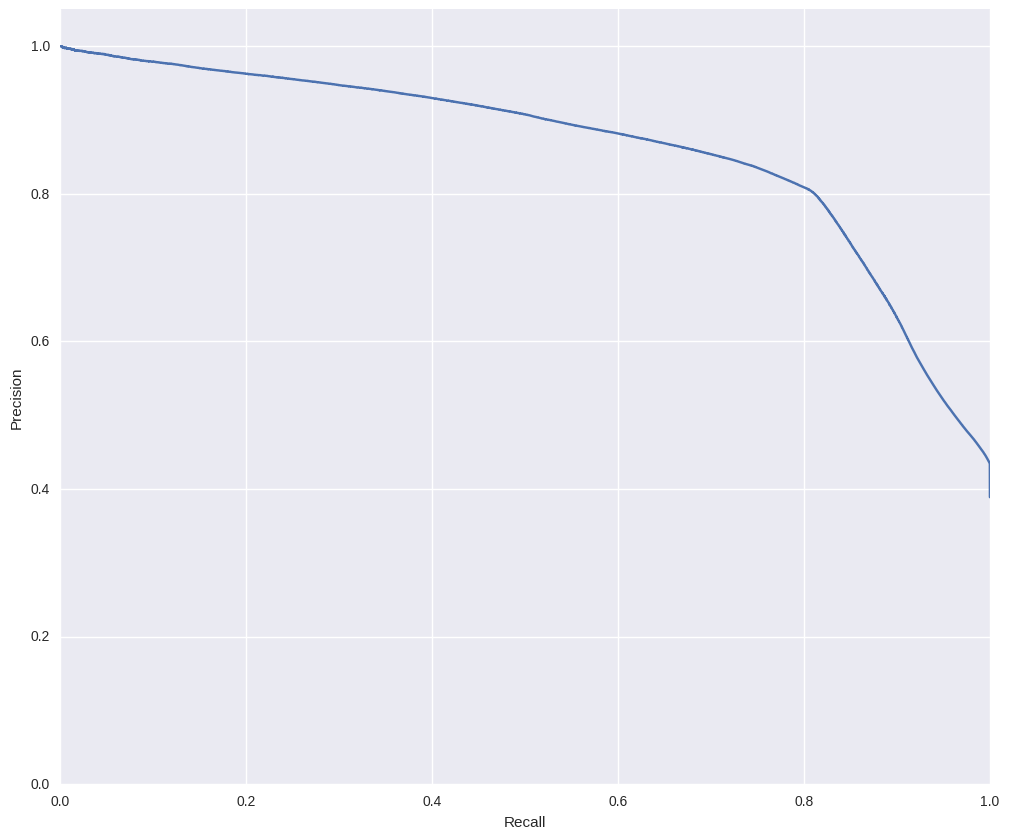

In [203]:
fig = plt.figure(figsize=(12, 10))
plt.plot(recalls, precisions)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')